# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import os
from joblib import Parallel, delayed  
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tabulate import tabulate

nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
hp = pd.read_csv('data/df_original.csv', encoding='utf-8')
hp.head()

,Unnamed: 0,Autor,Titel,Übersetzer,Original_Titel,ISBN,Datum,Text,removed_stop_word_lower,removed_stop_word,number_of_tokens,number_of_types,clean_text,network_text
0,0,J.K. Rowling,HARRY POTTER und der Gefangene von Askaban,Klaus Fritz,Harry Potter and the Prisoner of Azkaban,978-1-78110-057-8,1999,"\n\n\nFür Jill Prewett und Aine Kiely,\n\ndie ...","\n\n\nfür jill prewett und aine kiely,\n\ndie ...","jill prewett aine kiely, patinnen souls inhalt...",115980.0,19479.0,jill prewett aine kiely patinnen souls inhalt ...,für jill prewett und aine kiely die patinne...
1,1,J.K. Rowling,HARRY POTTER und der Halbblutprinz,Klaus Fritz,Harry Potter and the Half-Blood Prince,978-1-78110-060-8,2005,"\n\n\nMackenzie,\n\nmeiner schönen Tochter,\n\...","\n\n\nmackenzie,\n\nmeiner schönen tochter,\n\...","mackenzie, schönen tochter, widme zwilling tin...",179884.0,26838.0,mackenzie schönen tochter widme zwilling tinte...,mackenzie meiner schönen tochter widme ich...
2,2,J.K. Rowling,HARRY POTTER und der Orden des Phönix,Klaus Fritz,Harry Potter and the Order of the Phoenix,978-1-78110-059-2,2003,"\n\n\n\n\nFür Neil, Jessica und David,\n\ndie ...","\n\n\n\n\nfür neil, jessica und david,\n\ndie ...","neil, jessica david, welt verzaubern inhalt du...",268898.0,35356.0,neil jessica david welt verzaubern inhalt dudl...,für neil jessica und david die meine welt ...
3,3,J.K. Rowling,HARRY POTTER und der Stein der Weisen,Klaus Fritz,Harry Potter and the Philosopher’s Stone,978-1-78110-055-4,1997,"\n\n\n\nFür Jessica, für Anne und fü Di;\n\nJe...","\n\n\n\nfür jessica, für anne und fü di;\n\nje...","jessica, anne fü di; jessica mag geschichten, ...",84152.0,15910.0,jessica anne fü di jessica mag geschichten ann...,für jessica für anne und fü di jessica mag ...
4,4,J.K. Rowling,HARRY POTTER und die Heiligtümer des Todes,Klaus Fritz,Harry Potter and the Deathly Hallows,978-1-78110-061-5,2007,\n\n\nDie\n\nWidmung\n\ndieses Buches\n\nist\n...,\n\n\ndie\n\nwidmung\n\ndieses buches\n\nist\n...,"widmung buches siebengeteilt: neil, jessica, d...",207576.0,29725.0,widmung buches siebengeteilt neil jessica davi...,die widmung dieses buches ist siebengete...


In [3]:
stopwords = stopwords.words('german')

In [4]:
# Hilfsfunktion zur Bereinigung und Tokenisierung

def sentence_to_wordlist(raw:str):
    
    text = re.sub('[^A-Za-z_äÄöÖüÜß]',' ', raw).split()
    filtered_text = [word for word in text if word not in stopwords]
    return filtered_text
    

In [5]:
# Hilfsfunktion zur Extraktion der Sätze
# gibt eine List von tokenisierten Sätzen aus 
# berücksichtigt auch Bigramme

def prepare_text(raw_text):
    raw_sentences = tokenizer.tokenize(str(raw_text).lower())
    tokenized_sentences = Parallel(n_jobs=-1)(delayed(sentence_to_wordlist)(raw_sentence) for raw_sentence in raw_sentences)
    phrases = Phrases(tokenized_sentences)
    bigram = Phraser(phrases)
    sentences = list(bigram[tokenized_sentences])
    return sentences

In [6]:
text1 = hp.Text[0] 
text2 = hp.Text[1]
text3 = hp.Text[2]
text4 = hp.Text[3]
text5 = hp.Text[4]
text6 = hp.Text[5]
text7 = hp.Text[6]

books = text1+text2+text3+text4+text5+text6+text7

In [7]:
sentences = prepare_text(books)

# sentences ist eine Liste von tokenisierten Sätzen, zum Beispiel:
print(sentences[1000])

['kamen', 'wachen_askaban', 'redeten']


# Training von Word2Vec (mit Gensim)

In [8]:
# Paramter setzen
workers = 4
seed = 42 #just because

In [9]:
# Training
w2v_hp1_7 = Word2Vec(sentences=sentences, 
                   size=300, window=7, 
                   min_count=3, workers=workers, 
                   sg=1, seed=seed)

# trainiertes Modell speichern
w2v_hp1_7.save(os.path.join('trained_models', 'hp1_7_w2v.bin'))

In [10]:
# trainiertes Modell laden
w2v_hp1_7 = Word2Vec.load(os.path.join('trained_models', 'hp1_7_w2v.bin'))

# Exploration des Word2Vec-Modells

## Wörter als Vektoren

In [11]:
# Vergleicht 2 Vektoren (Cosinus Similarität)

w2v_hp1_7.similarity('harry', 'ron')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


0.49535522

In [12]:
w2v_hp1_7.similarity('harry', 'besen')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.55301106

In [13]:
# Wortvektoren als DataFrame 

tsne = TSNE(n_components=2, random_state=seed)
word_vectors = w2v_hp1_7.wv.syn0
word_vectors_2d = tsne.fit_transform(word_vectors)

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_vectors_2d[w2v_hp1_7.wv.vocab[word].index])
            for word in w2v_hp1_7.wv.vocab
        ]
    ],
    columns=['word', 'x', 'y'])

# random 5 Wörter und ihre Koordinaten ausgeben
points.sample(5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


,word,x,y
3733,rauschte,25.350965,55.466000
10118,prüfend,1.906796,16.091879
17660,leintüchern,54.733116,-23.690542
17111,angelehnt,45.799622,-38.119968
13479,lektionen,-41.824417,-37.984333


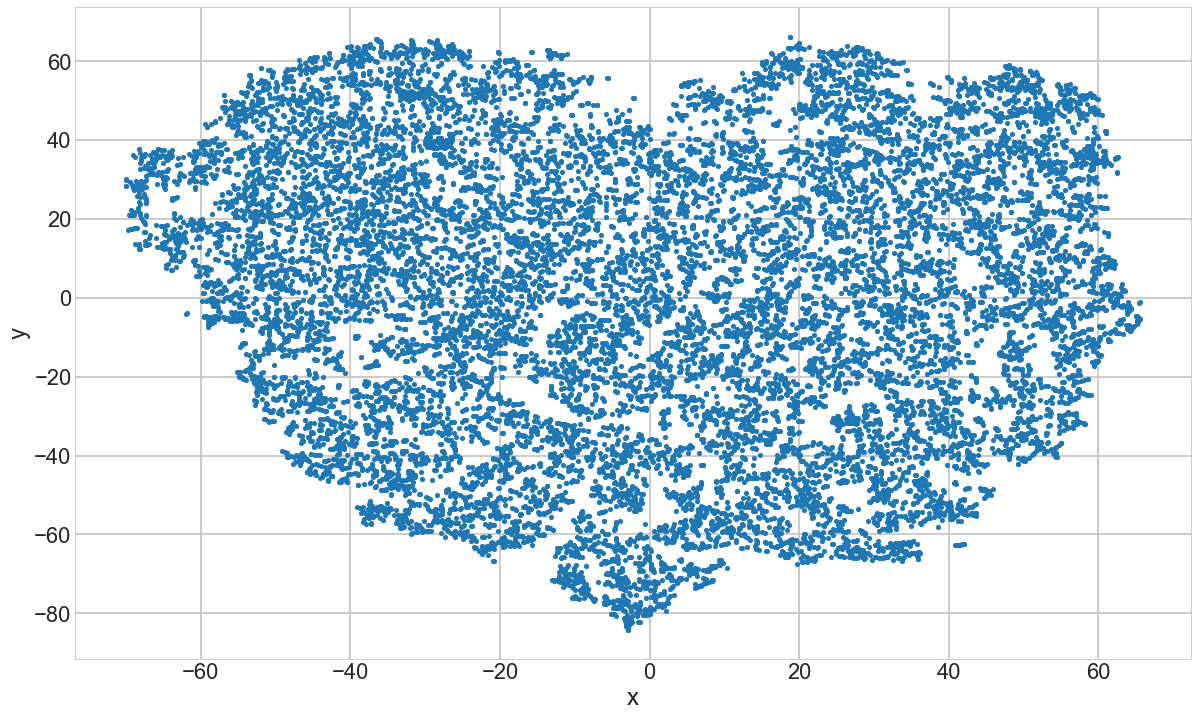

In [14]:
# alle Wortvektoren plotten

sns.set_context('poster')

plt.style.use('seaborn-whitegrid')
points.plot.scatter('x', 'y', s=10, figsize=(20, 12))

In [15]:
# Hilfsfunktion, um durch den Plot zu navigieren (ranzoomen)

def plot_region(x_bounds, y_bounds, padding=0.005, fontsize=11):
    myslice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])]
    
    ax = myslice.plot.scatter('x', 'y', s=35, figsize=(9, 5))
    for i, point in myslice.iterrows():
        ax.text(point.x + padding, point.y + padding, point.word, fontsize=fontsize)

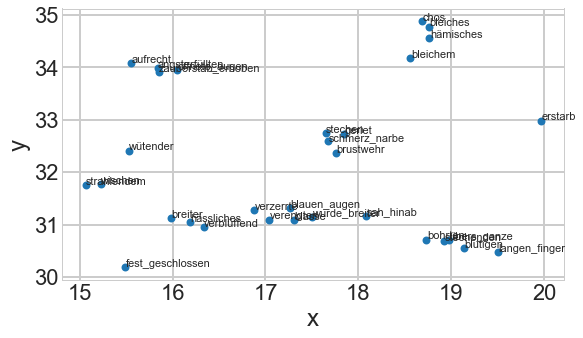

In [16]:
# ranzoomen
x_bounds = (15, 20)       # Bereich x-Achse einstellen
y_bounds = (30, 35)       # Bereich y-Achse einstellen

myslice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])]

len(myslice)

plot_region(x_bounds=x_bounds, y_bounds=y_bounds)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


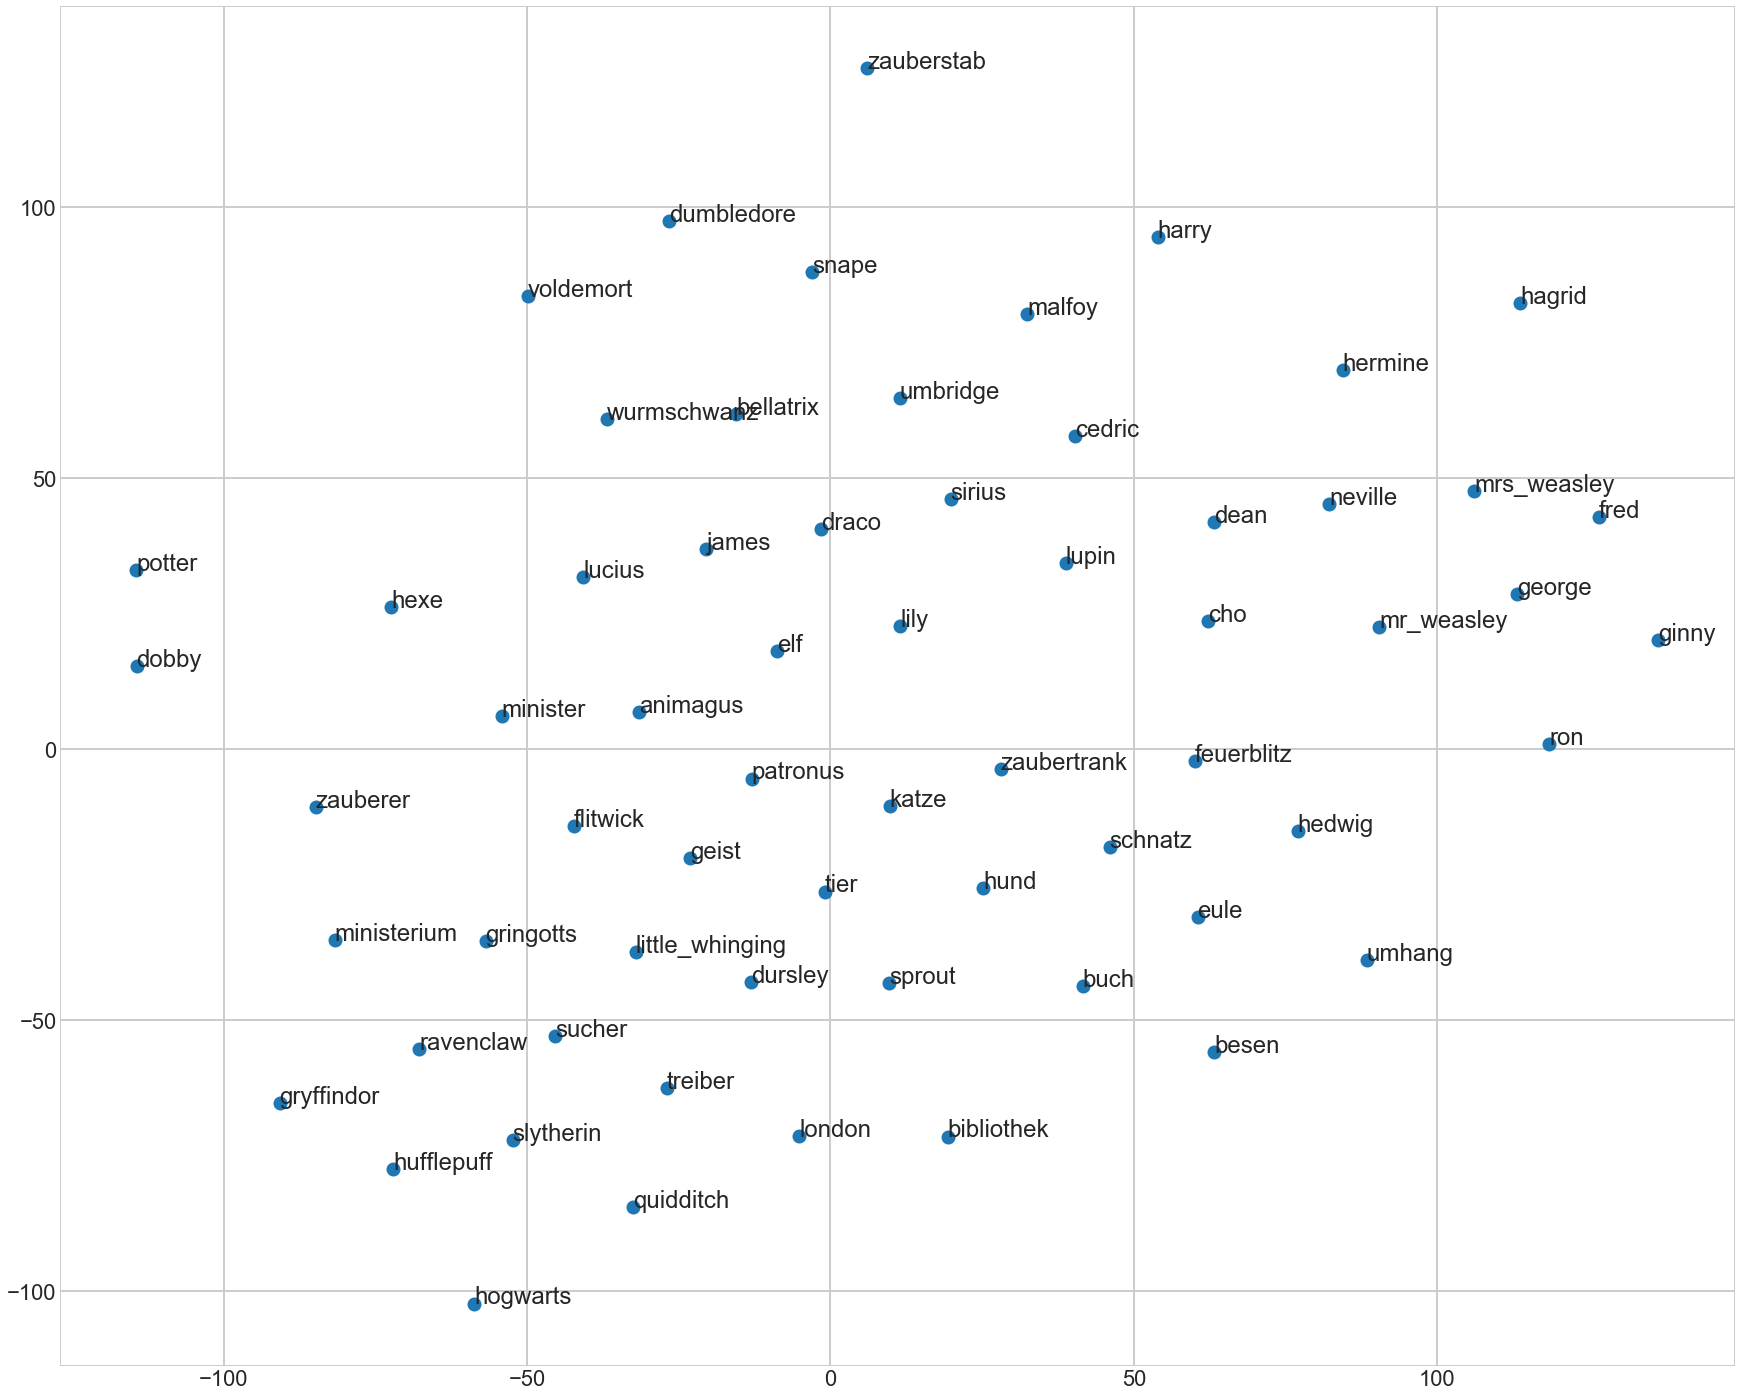

In [18]:
# nur ausgewählte Wortvektoren plotten

tsne = TSNE(n_components=2, random_state=seed)

words =  ['harry', 'potter', 'ron', 'hermine', 'ginny', 'dean', 'neville', 'cho', 'fred', 'george', 
          'mr_weasley', 'mrs_weasley', 'cedric', 'voldemort', 'bellatrix', 'malfoy', 'draco', 'lucius', 'sirius', 
          'james', 'lupin', 'wurmschwanz', 'lily', 'dobby', 'elf', 'zauberer', 'hexe', 'hogwarts',
          'gryffindor', 'slytherin', 'ravenclaw', 'hufflepuff',
          'sprout', 'flitwick', 'hagrid', 'dumbledore', 'snape', 'umbridge', 'minister', 'ministerium',
          'little_whinging', 'london', 'dursley', 'gringotts',
          'quidditch', 'besen', 'feuerblitz', 'schnatz', 'sucher', 'treiber', 'bibliothek', 'buch', 'geist',
          'eule', 'katze', 'hedwig', 'hund', 'patronus', 'tier', 'animagus', 'umhang', 'zauberstab', 'zaubertrank']

vectors = [w2v_hp1_7[word] for word in words]
plt.figure(figsize=[30,25])
plt.style.use('seaborn-whitegrid')
Y = tsne.fit_transform(vectors[:200])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## Ähnliche Wörer

In [19]:
w2v_hp1_7.most_similar(positive=['harry'], topn=5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('malfoy', 0.7832978963851929),
 ('dagegen', 0.7430057525634766),
 ('runde', 0.7410215139389038),
 ('aufmerksam', 0.7348706722259521),
 ('verzweifelt', 0.7338876724243164)]

In [20]:
w2v_hp1_7.most_similar(positive=['quidditch'], topn=5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mannschaft', 0.9700076580047607),
 ('sucher', 0.9614822268486023),
 ('hüter', 0.9552851915359497),
 ('kapitän', 0.9543976783752441),
 ('verwandlung', 0.9533519148826599)]

In [21]:
w2v_hp1_7.most_similar(positive=['hexe'], topn=5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('kleine', 0.9230378866195679),
 ('kleiner', 0.9208781719207764),
 ('großer', 0.9183794260025024),
 ('kleines', 0.9148468375205994),
 ('große', 0.9027644395828247)]

In [22]:
# Hilfsfunktion zum Plotten ähnlicher Wörter im Vektorraum

def plot_closest_words(model, word, plot_style):
    
    arr = np.empty((0,300), dtype='f') 
    closest_words = model.similar_by_word(word)
    word_labels = [word]
    arr = np.append(arr, np.array([model[word]]), axis=0)
    
    for wrd_score in closest_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
                
    plt.figure(figsize=[12,6])
    plt.style.use(plot_style)
                    
    tsne = TSNE(n_components=2, random_state=42)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()     

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


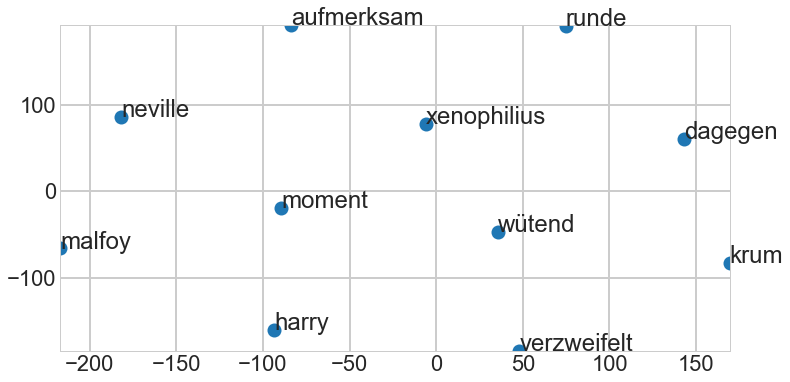

In [24]:
plot_closest_words(w2v_hp1_7, 'harry', 'seaborn-whitegrid')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


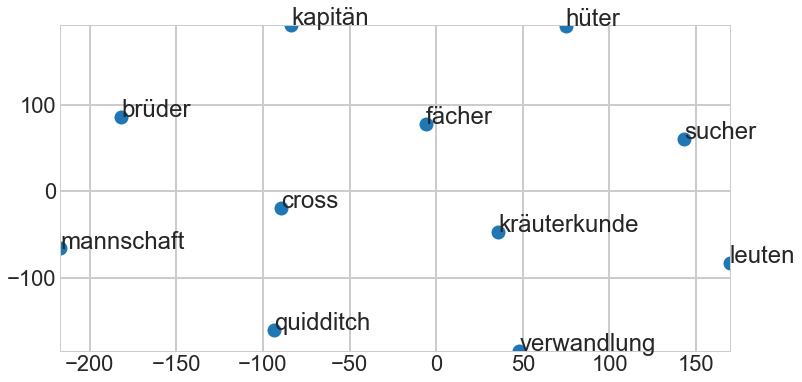

In [32]:
plot_closest_words(w2v_hp1_7, 'quidditch', 'seaborn-whitegrid')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


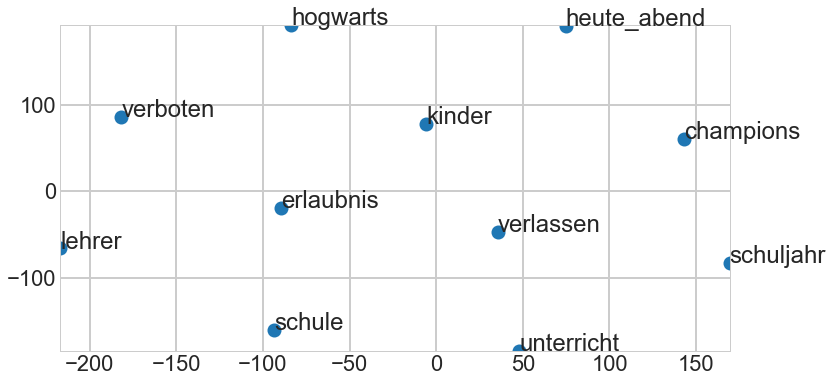

In [33]:
plot_closest_words(w2v_hp1_7, 'schule', 'seaborn-whitegrid')

## Verrechnung der Vektoren

In [34]:
# Hilfsfunktion zur Analogiebildung

def analogy(model, word1, word2, word3):
    similarities = model.most_similar(positive=[word1, word3], negative=[word2])
    word4 = similarities[0][0]
    print('{word1} steht in Beziehung zu {word2}, wie {word4} zu {word3}'.format(**locals()))
    return word4

In [41]:
analogy(w2v_hp1_7, 'schnatz', 'harry', 'ron')

schnatz steht in Beziehung zu harry, wie klatscher zu ron


C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


'klatscher'

In [40]:
analogy(w2v_hp1_7, 'gryffindor', 'harry', 'luna')

gryffindor steht in Beziehung zu harry, wie hufflepuff zu luna


C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


'hufflepuff'

In [ ]:
# nicht ganz :D aber besser